<a href="https://colab.research.google.com/github/Federiconunezfrau/DNN-diff-robot-trayectory-follow/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se entrena a la red neuronal, que luego se utilizará para seguir la trayectoria. Se utiliza Tensorflow

In [ ]:
import tensorflow as tf

import numpy as np

from google.colab import files

import matplotlib.pyplot as plt

In [ ]:
npz_trayectorias = np.load('trayectorias_ref_deseada.npz')

keys = npz_trayectorias.files

Tr = npz_trayectorias[keys[0]]
Td = npz_trayectorias[keys[1]]

N = Tr.shape[1]

In [ ]:
# NO USAR ESTA CELDA!

# parámetro que indica cuántas entradas tendrá la red neuronal.
# en total tendrá 3*(L+1) entradas y 2 salidas

L = 2

i = 0

# lista donde se irán guardando las entradas de la red neuronal
DNN_inputs = []

# lista donde se irán guardando las salidas deseadas de la red neuronal
DNN_outputs = []

while (i+1+L < N):
    
    
    a = Tr[:,i:i+1+L]
    b = Td[:,i]
    
    DNN_inputs.append(a)
    DNN_outputs.append(b)
    
    i += 1

M = len(DNN_inputs)

# Una vez que terminé, genero los vectores columna de entrada para la red
# neuronal. Cada entrada de la red neuronal es un vector de 
# 3*(L+1) filas x 1 columna. Se genera una matriz "X" de 
# 3*(L+1) filas x M columnas.

aux = DNN_inputs[0]
X = np.reshape(aux.T,(3*(L+1),1))

aux = DNN_outputs[0]
Y = np.reshape(aux,(2,1))

for j in range(1,M):
    
    aux = DNN_inputs[j]
    x = np.reshape(aux.T,(3*(L+1),1))
    
    X = np.hstack((X,x))
    
    aux = DNN_outputs[j]
    y = np.reshape(aux,(2,1))
    Y = np.hstack((Y,y))

# patrones de entrada para la red
X = X.T

# salidas deseadas de la red
Y = Y.T

# dimensiones de entrada
N_input = X.shape[1]

# dimensiones de salida
N_output = Y.shape[1]

# neuronas de la capa oculta
N_middle = 1024

In [ ]:
# ESTA ES LA CELDA QUE HAY QUE USAR!
# Esta celda es para el caso con la referencia adelantada

trayectoria_recorrida = Tr.T
trayectoria_referencia = Td.T

i = 0

L = 2

DNN_inputs = []
DNN_outputs = []

while (i+1+L < N):
    a = trayectoria_recorrida[i:i+L+1]
    a.shape = (3*(L  + 1),)
    b = trayectoria_referencia[i+1]

    DNN_inputs.append(a)
    DNN_outputs.append(b)

    i+=1

M = len(DNN_inputs)

X = DNN_inputs[0]

Y = DNN_outputs[0]

for j in range(1,M):
    aux = DNN_inputs[j]
    X = np.vstack((X,aux))

    aux = DNN_outputs[j]
    Y = np.vstack((Y,aux))

# dimensiones de entrada
N_input = X.shape[1]

# dimensiones de salida
N_output = Y.shape[1]

# neuronas de la capa oculta
N_middle = 1024

In [ ]:
X.shape

In [ ]:
# Creo la Red Neuronal
model = tf.keras.Sequential()

capas_ocultas = 1

# Capa de entrada
model.add(tf.keras.Input(shape=(N_input,)))
# Una capa oculta
model.add(tf.keras.layers.Dense(N_middle,
                                activation = 'relu',
                                kernel_initializer = 'glorot_uniform',
                                bias_initializer = 'glorot_uniform'))

model.add(tf.keras.layers.Dropout(0.5))
"""
model.add(tf.keras.layers.Dense(N_middle,
                                activation = 'relu',
                                kernel_initializer = 'glorot_uniform',
                                bias_initializer = 'glorot_uniform'))

model.add(tf.keras.layers.Dropout(0.5))

"""
# model.add(tf.keras.layers.Dense(N_middle,
                                # activation = 'relu',
                                # kernel_initializer = 'glorot_uniform',
                                # bias_initializer = 'glorot_uniform'))

# model.add(tf.keras.layers.Dropout(0.5))


# model.add(tf.keras.layers.Dense(N_middle,
                                # activation = 'relu',
                                # kernel_initializer = 'glorot_uniform',
                                # bias_initializer = 'glorot_uniform'))

# model.add(tf.keras.layers.Dropout(0.5))


model.add(tf.keras.layers.Dense(N_output,
                                activation = 'linear',
                                kernel_initializer = 'glorot_uniform',
                                bias_initializer = 'glorot_uniform'))

eta = 0.0003

opt = tf.keras.optimizers.Adam(learning_rate = eta)

model.compile(optimizer = opt,
              loss = 'mse')

In [ ]:
model.summary()

In [ ]:
# Se entrena la red neuronal

history = model.fit(X,Y, epochs = 4000, batch_size = 30, validation_split=0.1)

Text(0.5, 1.0, 'hidden = 1, units = 1024, Adam, L = 2, act = ReLu, eta = 0.0003')

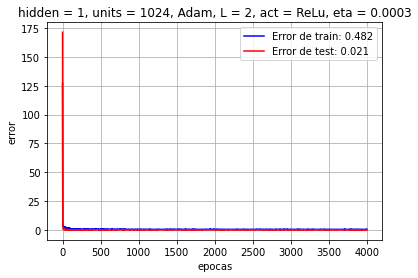

In [ ]:
# se grafica el error vs época
capas_ocultas = 1
eta = 0.0003

N_loss = len(history.history['loss'])
N_val_loss = len(history.history['val_loss'])

fig, ax = plt.subplots(1)
ax.plot(history.history['loss'],'b-',label = 'Error de train: %.3f' %(history.history['loss'][N_loss - 1]))
ax.plot(history.history['val_loss'],'r-',label = 'Error de test: %.3f' %(history.history['val_loss'][N_val_loss - 1]))

ax.set_xlabel('epocas')
ax.set_ylabel('error')
ax.legend()
ax.grid(True)
ax.set_title('hidden = %i, units = %i, Adam, L = %i, act = ReLu, eta = %.4f' %(capas_ocultas, N_middle, L, eta))

In [ ]:
fig.savefig('entrenamiento_L.png',dpi = 300)

In [ ]:
# Se exporta el modelo para después utilizarlo

tf.keras.models.save_model(model,"./saved_models")

# Se descarga el modelo para cargarlo en otro notebook
!zip -r /content/file.zip /content/saved_models
files.download("/content/file.zip")

In [ ]:
model.layers[4].weights